In [1]:
# Завантаження необхідних бібліотек і даних
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, t

# Завантаження даних (замініть шлях до файлу на ваш)
data = pd.read_csv(r'C:\Users\BOSS\Desktop\DATA\python_folder\poject_qvi\task2\QVI_data.csv')

# Перетворення дат і створення місячного ідентифікатора
data['DATE'] = pd.to_datetime(data['DATE'])
data['YEARMONTH'] = data['DATE'].dt.year * 100 + data['DATE'].dt.month

# Розрахунок метрик для кожного магазину по місяцях
measure_over_time = data.groupby(['STORE_NBR', 'YEARMONTH']).agg(
    totSales=('TOT_SALES', 'sum'),
    nCustomers=('LYLTY_CARD_NBR', 'nunique'),
    nTxnPerCust=('TXN_ID', lambda x: len(x) / x.nunique()),
    nChipsPerTxn=('PROD_QTY', lambda x: x.sum() / len(x)),
    avgPricePerUnit=('TOT_SALES', lambda x: x.sum() / data.loc[x.index, 'PROD_QTY'].sum())
).reset_index()

# Фільтрація магазинів із повними спостереженнями до лютого 2019 року
pre_trial_period = measure_over_time[measure_over_time['YEARMONTH'] < 201902]
stores_with_full_obs = pre_trial_period['STORE_NBR'].value_counts()[lambda x: x == 12].index
pre_trial_measures = pre_trial_period[pre_trial_period['STORE_NBR'].isin(stores_with_full_obs)]

# Функції для обчислення кореляції та відстані

def calculate_correlation(input_table, metric_col, store_comparison):
    store_numbers = input_table['STORE_NBR'].unique()
    corr_table = []

    for store in store_numbers:
        trial_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
        control_data = input_table[input_table['STORE_NBR'] == store][metric_col]
        correlation, _ = pearsonr(trial_data, control_data)
        corr_table.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': correlation})

    return pd.DataFrame(corr_table)

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    store_numbers = input_table['STORE_NBR'].unique()
    dist_table = []

    for store in store_numbers:
        trial_data = input_table[input_table['STORE_NBR'] == store_comparison][metric_col]
        control_data = input_table[input_table['STORE_NBR'] == store][metric_col]
        measure_diff = abs(trial_data.values - control_data.values)
        standardized_diff = 1 - (measure_diff - measure_diff.min()) / (measure_diff.max() - measure_diff.min())
        avg_standardized_diff = np.mean(standardized_diff)
        dist_table.append({'Store1': store_comparison, 'Store2': store, 'mag_measure': avg_standardized_diff})

    return pd.DataFrame(dist_table)

# Вибір контрольного магазину
trial_store = 77

# Кореляція за кількістю продажів і клієнтів
corr_sales = calculate_correlation(pre_trial_measures, 'totSales', trial_store)
corr_customers = calculate_correlation(pre_trial_measures, 'nCustomers', trial_store)

# Відстань за кількістю продажів і клієнтів
mag_sales = calculate_magnitude_distance(pre_trial_measures, 'totSales', trial_store)
mag_customers = calculate_magnitude_distance(pre_trial_measures, 'nCustomers', trial_store)

# Об'єднання метрик
corr_weight = 0.5
score_sales = pd.merge(corr_sales, mag_sales, on=['Store1', 'Store2'])
score_sales['scoreSales'] = score_sales['corr_measure'] * corr_weight + score_sales['mag_measure'] * (1 - corr_weight)

score_customers = pd.merge(corr_customers, mag_customers, on=['Store1', 'Store2'])
score_customers['scoreCustomers'] = score_customers['corr_measure'] * corr_weight + score_customers['mag_measure'] * (1 - corr_weight)

# Остаточний рейтинг
final_score = pd.merge(score_sales, score_customers, on=['Store1', 'Store2'])
final_score['finalControlScore'] = (final_score['scoreSales'] + final_score['scoreCustomers']) / 2

# Вибір контрольного магазину
control_store = final_score[final_score['Store1'] == trial_store].sort_values(by='finalControlScore', ascending=False)['Store2'].iloc[1]
print(f'Контрольний магазин для Trial Store {trial_store}: {control_store}')

# Графік трендів продажів
trial_data = measure_over_time[measure_over_time['STORE_NBR'] == trial_store]
control_data = measure_over_time[measure_over_time['STORE_NBR'] == control_store]

plt.figure(figsize=(10, 6))
plt.plot(trial_data['YEARMONTH'], trial_data['totSales'], label='Trial Store')
plt.plot(control_data['YEARMONTH'], control_data['totSales'], label='Control Store')
plt.title('Total Sales Over Time')
plt.xlabel('YearMonth')
plt.ylabel('Total Sales')
plt.legend()
plt.show()

KeyError: 'Store1'

C:\Users\BOSS\AppData\Local\Temp\ipykernel_17856\377820133.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(promo_start, promo_end, color='red', alpha=0.2


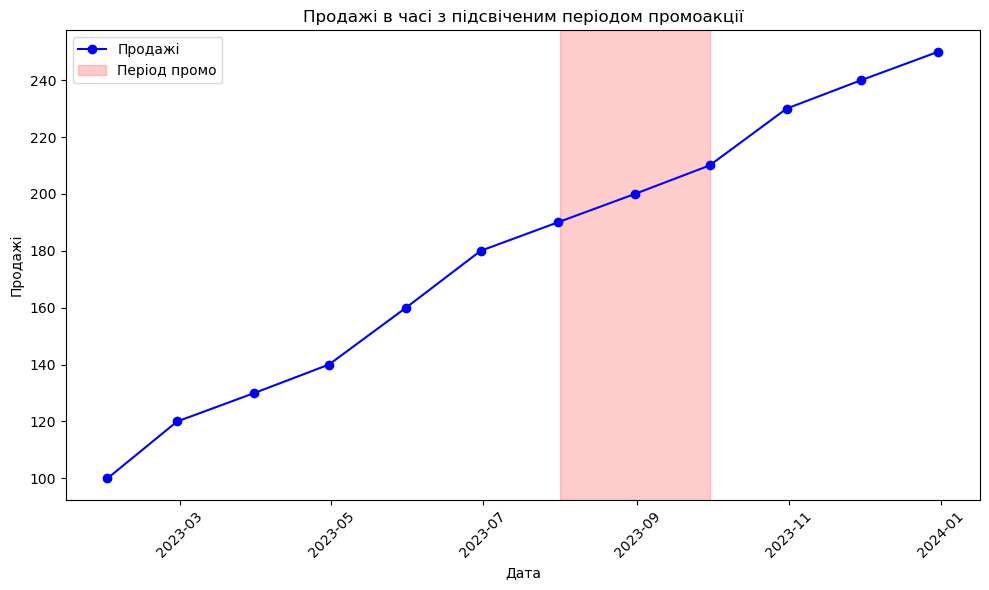

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Приклад даних
dates = pd.date_range('2023-01-01', periods=12, freq='M')
sales = [100, 120, 130, 140, 160, 180, 190, 200, 210, 230, 240, 250]

# Створення DataFrame
data = pd.DataFrame({'Date': dates, 'Sales': sales})

# Визначення періоду промо (наприклад, з серпня по вересень)
promo_start = '2023-08-01'
promo_end = '2023-09-30'

# Створення графіку
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Sales'], label='Продажі', color='blue', marker='o')

# Додавання підсвічування періоду промо з чорним контуром
plt.axvspan(promo_start, promo_end, color='red', alpha=0.2
            , label='Період промо', edgecolor='black')

# Додавання заголовку та міток
plt.title('Продажі в часі з підсвіченим періодом промоакції')
plt.xlabel('Дата')
plt.ylabel('Продажі')
plt.legend()

# Показати графік
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:

print(sum(a))

51


In [25]:
n=len(a)
print(n)
print(n*(n+1)/2)

9
45.0


In [41]:
a=[1,2,3,5,6,7,8,9,10]

def miss_values(num):
    n= len(num)
    actua_sum=sum(num)
    expect_sum= n*(n+1)/2
    return actua_sum-expect_sum
print(miss_values(a))

6.0


In [35]:
miss_values(a)

6.0

In [2]:
a = [2, 4, 5, 6]

def miss_values(num):
    n = max(num)  # Визначаємо максимальне число в списку
    actual_sum = sum(num)  # Реальна сума чисел у списку
    expected_sum = n * (n + 1) // 2  # Очікувана сума від 1 до n
    return expected_sum - actual_sum  # Різниця дає суму пропущених чисел

print(miss_values(a))
# Створення графіку
plt.figure(figsize=(10, 6))
plt.plot(a, label='Числа в списку', color='blue', marker='o')

# Додавання заголовку та міток
plt.title('Графік чисел у списку')
plt.xlabel('Індекс')
plt.ylabel('Значення')
plt.legend()

# Показати графік
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


4


NameError: name 'plt' is not defined

In [47]:
print(len(a))
print(max(a))


4
6


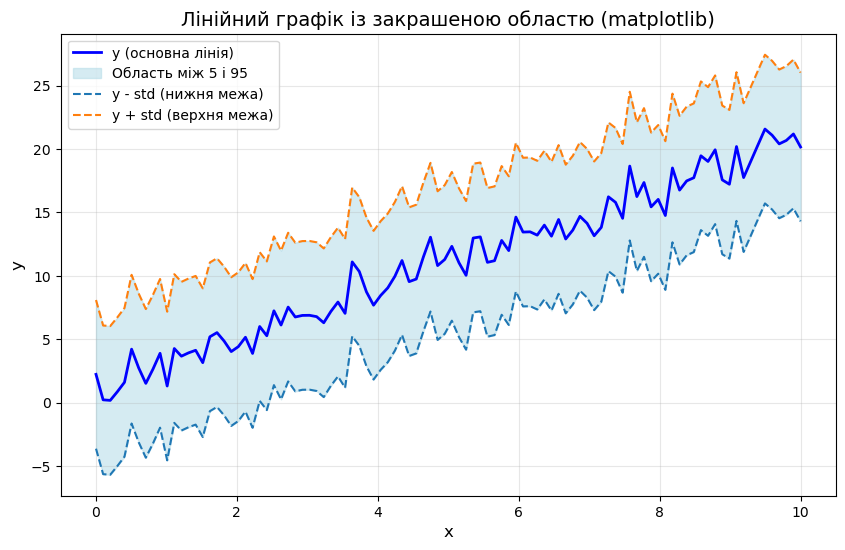

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Генеруємо дані
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.size)

# Створюємо DataFrame для зручності
data = pd.DataFrame({"x": x, "y": y})
std = np.std(y)

data['5'] = data['y'] - std
data['95'] = data['y'] + std

# Побудова графіка
plt.figure(figsize=(10, 6))

# Основна лінія
plt.plot(data['x'], data['y'], label='y (основна лінія)', color='blue', linewidth=2)

# Закрашування області між лініями
plt.fill_between(data['x'], data['5'], data['95'], color='lightblue', alpha=0.5, label='Область між 5 і 95')

# Графіки для меж
plt.plot(data['x'], data['5'], label='y - std (нижня межа)',  linestyle='--')
plt.plot(data['x'], data['95'], label='y + std (верхня межа)', linestyle='--', alp)

# Додавання підписів та легенди
plt.title("Лінійний графік із закрашеною областю (matplotlib)", fontsize=14)
plt.xlabel("x", fontsize=12)
plt.ylabel("y", fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.3)


In [6]:
x = np.linspace(0, 10, 100)
y = 2 * x + 1 + np.random.normal(0, 1, size=x.size)

# Створюємо DataFrame для зручності
data = pd.DataFrame({"x": x, "y": y})
std= np.std(y)

data['5']= data['y']-std
data['95']= data['y']+std

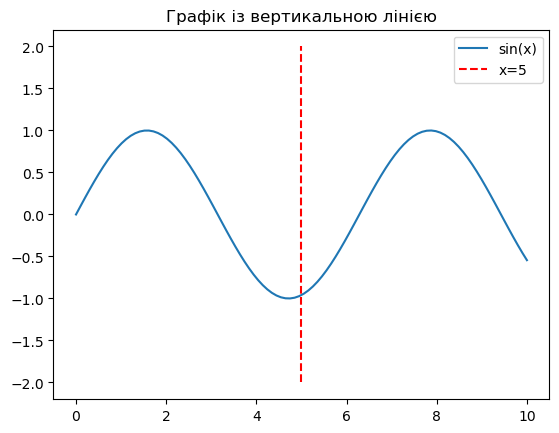

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y = np.sin(x)

plt.plot(x, y, label='sin(x)')
plt.vlines(x=5, ymin=-2, ymax=2, colors='red', linestyles='--', label='x=5')
plt.title("Графік із вертикальною лінією")
plt.legend()
plt.show()
